In [1]:
import sys
sys.path.append('../')

import gym
from gym import logger as gymlogger
gymlogger.set_level(40)

import torch
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from agent import *
from model import *

In [2]:
env = gym.make('LunarLander-v2')
o_dim = env.observation_space.shape[0]
a_dim = env.action_space.n
print('State shape: ', o_dim)
print('Number of actions: ', a_dim)

State shape:  8
Number of actions:  4


In [3]:
def train_agent(tmax = 1000, num_episodes = 300, print_every = 50, eps_start = 1.0, eps_end = 0.1, eps_decay = 0.95):
    score_list = []
    score_window = deque(maxlen = print_every) 
    best_score = 150.0
    eps = eps_start
    for e in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for t in range(tmax):
            action = agent.get_action(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        score_window.append(score)
        mean_score = np.mean(score_window)
        score_list.append([score, mean_score])
        
        print('\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score), end = "")
        if e % print_every == 0:
            print('\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score))
        if mean_score >= best_score:
            print('\rEpisode {}\tsum of rewards {:8.2f}\t saved!'.format(e, mean_score))
            torch.save(agent.online_net.state_dict(), 'checkpoint.pth')
            best_score = mean_score
            
    return score_list
    

In [4]:
agent = DQNAgent(QNetwork, o_dim, a_dim, lr = 1e-3, algorithm = "ddqn")
print(agent.algorithm)
print(agent.loss_fn)
print(agent.online_net)

ddqn
SmoothL1Loss()
QNetwork(
  (main): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)


In [5]:
ddqn_score = train_agent()

Episode 50	sum of rewards  -124.85
Episode 100	sum of rewards   -69.31
Episode 150	sum of rewards    72.19
Episode 200	sum of rewards   139.89
Episode 231	sum of rewards   151.73	 saved!
Episode 233	sum of rewards   154.55	 saved!
Episode 236	sum of rewards   156.10	 saved!
Episode 237	sum of rewards   157.87	 saved!
Episode 242	sum of rewards   160.89	 saved!
Episode 243	sum of rewards   162.52	 saved!
Episode 246	sum of rewards   163.98	 saved!
Episode 247	sum of rewards   165.16	 saved!
Episode 248	sum of rewards   165.40	 saved!
Episode 250	sum of rewards   162.52
Episode 251	sum of rewards   165.44	 saved!
Episode 252	sum of rewards   172.05	 saved!
Episode 253	sum of rewards   174.82	 saved!
Episode 300	sum of rewards   136.29


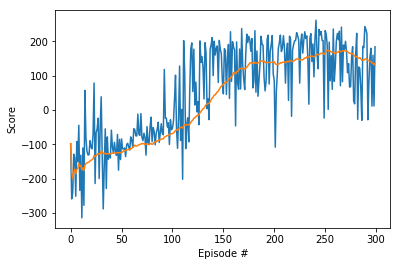

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(ddqn_score)), ddqn_score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
# load checkpoint
agent.online_net.load_state_dict(torch.load('checkpoint.pth'))
# load to cpu and save the best weights
torch.save(agent.online_net.cpu().state_dict(), "ddqn_LunarLander.pth")

In [9]:
env.close()